In [1]:
use_cuda_numpy = False
if use_cuda_numpy:
    import numpy as np
    import matplotlib.pyplot as plt
    import cupy as cnp
    from time import time
    import os
    
else:
    import numpy as cnp
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import os

# $M$, $ND$ Newtonain Interacting Universe Simulator

### Routines

In [2]:
def get_gradient_vector_field_3D(potential_field, real_dtype, dx, dy, dz):
    # Assumes potential_field is [Nx, Ny, Nz]
    gradient = cnp.zeros(potential_field.shape+(3,), dtype=real_dtype)
    # X
    # boundaries with simple Euler formula O(dx)
    gradient[ 0, :, :, 0] = (potential_field[1, :, :]-potential_field[0, :, :])/dx
    gradient[ -1, :, :, 0] = (potential_field[-1, :, :]-potential_field[-2, :, :])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[ 1,:,:, 0] = (potential_field[2,:,:]-potential_field[0,:,:])/(2*dx)
    gradient[ -2,:,:, 0] = (potential_field[-1,:,:]-potential_field[-3,:,:])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[ 2:-2,:,:, 0] = (-potential_field[4:,:,:]+8*potential_field[3:-1,:,:]-8*potential_field[1:-3,:,:]+potential_field[:-4,:,:])/(12*dx)

    # DY
    # boundaries with simple Euler formula O(dx)
    gradient[ :, 0, :, 1] = (potential_field[:,1, :]-potential_field[:,0, :])/dx
    gradient[ :,-1, :, 1] = (potential_field[:,-1, :]-potential_field[:,-2, :])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[ :,1,:, 1] = (potential_field[:,2,:]-potential_field[:,0,:])/(2*dx)
    gradient[ :,-2,:, 1] = (potential_field[:,-1,:]-potential_field[:,-3,:])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[ :,2:-2,:, 1] = (-potential_field[:,4:,:]+8*potential_field[:,3:-1,:]-8*potential_field[:,1:-3,:]+potential_field[:,:-4,:])/(12*dx)

    # DZ
    # boundaries with simple Euler formula O(dx)
    gradient[ :,:,0, 2] = (potential_field[:,:,1]-potential_field[:,:,0])/dx
    gradient[ :,:,-1, 2] = (potential_field[:,:,-1]-potential_field[:,:,-2])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[ :,:,1, 2] = (potential_field[:,:,2]-potential_field[:,:,0])/(2*dx)
    gradient[ :,:,-2, 2] = (potential_field[:,:,-1]-potential_field[:,:,-3])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[ :,:,2:-2, 2] = (-potential_field[:,:,4:]+8*potential_field[:,:,3:-1]-8*potential_field[:,:,1:-3]+potential_field[:,:,:-4])/(12*dx)
    return gradient



def get_gradient_vector_field_2D(potential_field, real_dtype, dx, dy):
    # Assumes potential_field is [Nx, Ny]
    gradient = cnp.zeros(potential_field.shape+(2,), dtype=real_dtype)
    # X
    # boundaries with simple Euler formula O(dx)
    gradient[0, :, 0] = (potential_field[1, :]-potential_field[0, :])/dx
    gradient[-1, :, 0] = (potential_field[-1, :]-potential_field[-2, :])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[1,:, 0] = (potential_field[2,:]-potential_field[0,:])/(2*dx)
    gradient[-2,:, 0] = (potential_field[-1,:]-potential_field[-3,:])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[2:-2,:, 0] = (-potential_field[4:,:]+8*potential_field[3:-1,:]-8*potential_field[1:-3,:]+potential_field[:-4,:])/(12*dx)

    # DY
    # boundaries with simple Euler formula O(dx)
    gradient[:, 0, 1] = (potential_field[:,1]-potential_field[:,0])/dy
    gradient[:,-1, 1] = (potential_field[:,-1]-potential_field[:,-2])/dy
    # next boundaries with centered difference O(dx**2)
    gradient[:,1, 1] = (potential_field[:,2]-potential_field[:,0])/(2*dy)
    gradient[:,-2, 1] = (potential_field[:,-1]-potential_field[:,-3])/(2*dy)
    # rest with O(dx**4) centered difference
    gradient[:,2:-2, 1] = (-potential_field[:,4:]+8*potential_field[:,3:-1]-8*potential_field[:,1:-3]+potential_field[:,:-4])/(12*dy)
    return gradient

def get_gradient_vector_field_1D(potential_field, real_dtype, dx):
    # Assumes potential_field is [Nx]
    gradient = cnp.zeros(potential_field.shape+(1,), dtype=real_dtype)
    # X
    # boundaries with simple Euler formula O(dx)
    gradient[0,0] = (potential_field[1]-potential_field[0])/dx
    gradient[-1,0] = (potential_field[-1]-potential_field[-2])/dx
    # next boundaries with centered difference O(dx**2)
    gradient[1,0] = (potential_field[2]-potential_field[0])/(2*dx)
    gradient[-2,0] = (potential_field[-1]-potential_field[-3])/(2*dx)
    # rest with O(dx**4) centered difference
    gradient[2:-2,0] = (-potential_field[4:]+8*potential_field[3:-1]-8*potential_field[1:-3]+potential_field[:-4])/(12*dx)
    return gradient #[Nx,1]


def interpolate_traj_force_from_force_field_3D(trajs, force_field, xs, ys, zs):
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs[:,:3]-xlowers)//dxs).T).astype(cnp.uint) # [3, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,cnp.newaxis]
    raty_down = ((trajs[:,1]-ys[ trajs_idxs[1] ])/(ys[ trajs_idxs[1]+1 ]-ys[ trajs_idxs[1] ]))[:,cnp.newaxis]
    ratz_down = ((trajs[:,2]-zs[ trajs_idxs[2] ])/(zs[ trajs_idxs[2]+1 ]-zs[ trajs_idxs[2] ]))[:,cnp.newaxis]
    # Get the interpolated force
    return ratx_down*raty_down*ratz_down* force_field[ trajs_idxs[0]+1, trajs_idxs[1]+1, trajs_idxs[2]+1 ] +\
        (1-ratx_down)*raty_down*ratz_down* force_field[ trajs_idxs[0], trajs_idxs[1]+1, trajs_idxs[2]+1 ] +\
        ratx_down*(1-raty_down)*ratz_down* force_field[ trajs_idxs[0]+1, trajs_idxs[1], trajs_idxs[2]+1 ] +\
        ratx_down*raty_down*(1-ratz_down)* force_field[ trajs_idxs[0]+1, trajs_idxs[1]+1, trajs_idxs[2] ] +\
        (1-ratx_down)*(1-raty_down)*ratz_down* force_field[ trajs_idxs[0], trajs_idxs[1], trajs_idxs[2]+1 ] +\
        ratx_down*(1-raty_down)*(1-ratz_down)* force_field[ trajs_idxs[0]+1, trajs_idxs[1], trajs_idxs[2] ] +\
        (1-ratx_down)*raty_down*(1-ratz_down)* force_field[ trajs_idxs[0], trajs_idxs[1]+1, trajs_idxs[2] ] +\
        (1-ratx_down)*(1-raty_down)*(1-ratz_down)* force_field[ trajs_idxs[0], trajs_idxs[1], trajs_idxs[2] ]
    
def interpolate_traj_force_from_force_field_2D(trajs, force_field, xs, ys):
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs[:,:2]-xlowers)//dxs).T).astype(cnp.uint) # [2, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,cnp.newaxis]
    raty_down = ((trajs[:,1]-ys[ trajs_idxs[1] ])/(ys[ trajs_idxs[1]+1 ]-ys[ trajs_idxs[1] ]))[:,cnp.newaxis]
    # Interpolate momentum
    return ratx_down*raty_down* force_field[ trajs_idxs[0]+1, trajs_idxs[1]+1 ] +\
        (1-ratx_down)*raty_down* force_field[ trajs_idxs[0], trajs_idxs[1]+1] +\
        ratx_down*(1-raty_down)* force_field[ trajs_idxs[0]+1, trajs_idxs[1] ] +\
        (1-ratx_down)*(1-raty_down)* force_field[ trajs_idxs[0], trajs_idxs[1]] #[numTrajs,2]

def interpolate_traj_force_from_force_field_1D(trajs, force_field, xs):
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs-xlowers)//dxs).T).astype(cnp.uint) # [1, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,cnp.newaxis]
    # Interpolate momentum
    return ratx_down* force_field[ trajs_idxs[0]+1 ] +\
        (1-ratx_down)* force_field[ trajs_idxs[0] ]  #[numTrajs,1]


def estimate_pdf_from_trajs(trajs, grid, sigma, real_dtype, norm):
    pdf = cnp.zeros(grid.shape[:-1], dtype=real_dtype)
    # vectorizing is is too memory costly, it would require
    # one whole grid per trajectory! so better use a for loop
    N = 1/(np.sqrt((2*np.pi)**trajs.shape[-1])*sigma**trajs.shape[-1]*trajs.shape[0])
    for traj in trajs:
        pdf+=N*cnp.exp(
            np.sum( -(grid-traj)**2/(2*sigma)**2, -1)) # for arbitrary 
    return norm*pdf/cnp.sum(pdf) #[N1,N2,...]

def estimate_pdf_over_trajs(trajs, sigma, real_dtype):
    pdf = cnp.zeros(trajs.shape[0], dtype=real_dtype)
    N = 1/(np.sqrt((2*np.pi)**trajs.shape[-1])*sigma**trajs.shape[-1]*trajs.shape[0])
    for traj in trajs:
        pdf += N*cnp.exp(
            np.sum(-(trajs-traj)**2/(2*sigma)**2, -1) )
            
    return pdf #[numTrajs]

### Simulation Parameters

In [3]:
# If want to use reference TISE simulation for comparison, write
# the same experiment name and the paths to the outputs
exp_name = "torus2"
#TISE_path = f"./OUTPUTS/TISE_1D/{exp_name}/"
TISE_path = None

# Number precision
complex_dtype = cnp.csingle # 64 bit #cnp.cdouble # 128 bit
real_dtype = cnp.single # 32 bit # cnp.double # 64 bit

# Time increment
dt = 0.002

# The standard deviation of the kernel gaussians
sigma = 1


# IF USING TISE DATA AS REFERENCE! ###########################################
if TISE_path:
    with open(f"{TISE_path}/Settings.txt", "r") as f:
        numIts_TISE = int(f.readline().split("numIts ")[1])
        dt_TISE = float(f.readline().split("dt ")[1])
        outputEvery_TISE = int(f.readline().split("outputEvery ")[1])
        Ns_pdf = [int(x) for x in f.readline().split("Ns ")[1].split('[')[1].split(']')[0].split(',')]
        xlowers = [float(x) for x in f.readline().split("xlowers ")[1].split('[')[1].split(']')[0].split(',')]
        xuppers = [float(x) for x in f.readline().split("xuppers ")[1].split('[')[1].split(']')[0].split(',')]
        numDofUniv = int(f.readline().split("numDofUniv ")[1])
        numDofPartic = int(f.readline().split("numDofPartic ")[1])
        numTrajs = int(f.readline().split("numTrajs ")[1])
        hbar = float(f.readline().split("hbar ")[1])
        ms = [float(x) for x in f.readline().split("ms ")[1].split('[')[1].split(']')[0].split(',')]
        f.readline() # dtype complex
        f.readline() # dtype real
        try:
            K_coulomb = float(f.readline().split("K_coulomb ")[1])
            qs = [float(x) for x in f.readline().split("qs ")[1].split('[')[1].split(']')[0].split(',')]
        except:
            K_coulomb = 1
            qs=[1]*numDofPartic
        # Tricks to match the output frames - DO NOT EDIT THIS!
        # Adapt the chosen dt to the closest one such that it is possible to match frames
        # That is, make them commensurate
        if dt_TISE>dt:
            dt=int(dt_TISE//dt)**-1*dt_TISE
        else: # we need at least the same rate of outputs to compare one to one
            dt=dt_TISE

        print(f"Using dt={dt:.3}; dt_TISE={dt_TISE:.3} -> dt = {dt/dt_TISE:.3}*dt_TISE")
        use_external_forces_and_pdf_grid=True
        # Match the output number
        outputEvery = int(dt_TISE//dt)
        # now match exactly the outputed frames
        outputEvery = outputEvery_TISE*outputEvery

        # Total number of iterations
        numIts = int(numIts_TISE*(dt_TISE//dt))


        # Time grid
        ts = np.array([dt*j for j in range(numIts)])
        output_ts = ts[::outputEvery]
        ts_TISE = np.array([dt_TISE*j for j in range(numIts_TISE)])
        output_ts_TISE=ts_TISE[::outputEvery_TISE]
        
        fig=plt.figure(figsize=(12, 2))
        ax=fig.add_subplot(111)
        ax.vlines(ts[:2*outputEvery_TISE*int(dt_TISE//dt)], 0, 1,  label="Compute Newtonian time frames", color="red", linewidth=1)
        ax.vlines(ts[:2*outputEvery_TISE*int(dt_TISE//dt):outputEvery], 1, 2,  label="Output Newtonian time frames", color="black", linewidth=1)
        ax.vlines(ts_TISE[:2*outputEvery_TISE], -1, 0,  label="Calculated TISE time frames", color="blue", linewidth=1)
        ax.vlines(ts_TISE[:2*outputEvery_TISE:outputEvery_TISE], -1, -2,  label="Output TISE time frames", color="violet", linewidth=1)
        ax.legend()
        ax.set_xlabel("t")
        plt.show()
else: #####################################################################
    # IF NOT USING TISE DATA AS REFERENCE!
    # Number of Tangent Universes
    numTrajs=100

    # Number of Dimensions per Universe, aka configuration space
    numDofUniv = 3
    numDofPartic = 1
    
    numIts = 1600
    ts = np.array([dt*j for j in range(numIts)])
    
    outputEvery = 5

    # Masses per dof
    ms = cnp.array([1]*numDofUniv)[cnp.newaxis, :]

    # Constants
    K_coulomb=1
    hbar = 1
    qs=cnp.array([1]*(numDofUniv//numDofPartic))
    qs[-1]=-1

    # Intervals for calculating the wave function
    xlowers = [-5, -5, -5]
    xuppers = [5, 5, 5]    
    assert len(xlowers)==numDofUniv
    
    # If generating a N1 x N2 x N3 x...x NdofUniv x dofUniv is a reasonable thing
    use_external_forces_and_pdf_grid=False
    if use_external_forces_and_pdf_grid:
        # Spatial nodes for the pdf estimation and potential fields
        Ns_pdf = [100]*numDofUniv # (Nx, Ny, Nz)

For the potential and force fields

In [4]:
if use_external_forces_and_pdf_grid:
    Ns_potential = [100]*numDofUniv # (Nx, Ny, Nz)
    # Increments to be used per dimension
    dxs = [(xuppers[j]-xlowers[j])/(Ns_potential[j]-1) for j in range(numDofUniv)] # (dx, dy, dz)
    dxs = cnp.array(dxs)[cnp.newaxis,:]
    
    dxs_pdf = [(xuppers[j]-xlowers[j])/(Ns_pdf[j]-1) for j in range(numDofUniv)] # (dx, dy, dz)
    dxs_pdf = cnp.array(dxs_pdf)[cnp.newaxis,:]

    #Create coordinates at which the solution will be calculated
    nodes_pdf = [cnp.linspace(xlowers[j], xuppers[j], Ns_pdf[j]) for j in range(numDofUniv)] # (xs, ys, zs)
    nodes_potential = [cnp.linspace(xlowers[j], xuppers[j], Ns_potential[j]) for j in range(numDofUniv)] # (xs, ys, zs)
    # Create a node mesh sirve para 3D y 2D
    if numDofUniv==2 or numDofUniv==3:
        grid_pdf=cnp.moveaxis(cnp.array(cnp.meshgrid(*nodes_pdf)).swapaxes(1,2), 0,-1) #[Nx,Ny,Nz,3]
        grid_potential=cnp.moveaxis(cnp.array(cnp.meshgrid(*nodes_potential)).swapaxes(1,2), 0,-1) #[Nx,Ny,Nz,3]
    else:
        grid_pdf = nodes_pdf[0][:, np.newaxis] #[Nx, 1]
        grid_potential= nodes_potential[0][:, np.newaxis] #[Nx, 1]

xlowers = cnp.array(xlowers)[cnp.newaxis, :]
xuppers = cnp.array(xuppers)[cnp.newaxis, :]
ms = np.array(ms)[np.newaxis,:]

### Scenario


#### Sample trajectories if not using reference simulation!

In [5]:
if not TISE_path:
    # If psi(x,t)=R(x,t)e^{iS(x,t)/hbar}
    def pdf_gaussian(x,mus, sigmas): # R^2(x,t)
        # x assumed to be [numpoints, numDofUniv], mus & sigmas [numDofUniv]
        N = 1/(np.sqrt((2*np.pi)**x.shape[-1])*np.prod(sigmas))
        return N*np.exp(np.sum(-0.5*(x-mus)**2/sigmas**2, -1)) #[numPoints]
    
    def constant_momentum_vector(x, ps): # grad S(x,t) -> Integrable up to global phase
        return ps #[numDofUniv]
    # velocity field should be conservative
    
    def rejection_sampling(desired_num_samples, pdf_function,
                        max_of_pdf, xlowers, xuppers, trial_batch_size):
        """
        Method to sample x from X~f(x) that cannot be directly sampled
         - Get sample y from Y~g(y) that can be sampled
            You selected a point y in the support of g(y), which
            should contain f(x)'s support
         - Then if M*g(y) is for sure bigger than f(x) for all its support 
            we can take the line in the image of the graph that goes from 0
            till M*g(y) and get a random sample there. If it is below f(y)
            we keep it, else we leave it out.
            Aka sample u~Unif(0,1) and accept y if u*M*g(y)<f(y)
        In particular, we are going to use Y~Unif((0,1)^dofUniv)
        g(y1,y2,..ydofUniv) = 1 / (L_1*L_2*...*L_dofUniv)
        Mg(y) will be bigger than the support if M*max(g(y)) = max(f(x))
        aka M=max(f(x))/max(g(x)). 
        In particular max(g(x))=1 / (L_1*L_2*...*L_dofUniv). Thus
        M = (L_1*L_2*...*L_dofUniv)*max(f(x))
        So the check is u*M*g(y)<f(y) <-> u*(L1*L2**)*max(f(x))/(L1*L2**)<f(y)
        And the L products cancel each other. Just as if M=max(f(x)) and g(y)=1
        """
        Ls = xuppers-xlowers #[numDofUniv]
        #M = np.prod(Ls)*max_of_pdf
        accepted = np.array([[np.inf]*xuppers.shape[0]]) # we will discard it then
        rd = 0
        while len(accepted)<=desired_num_samples:
            trial_ys = np.random.uniform(0,1, 
                    size=(trial_batch_size, xlowers.shape[0])) #[trial_batch, numDofUniv]
            trial_ys = trial_ys*Ls+xlowers #[trial_batchm, numDofUniv]
            fs = pdf_function(trial_ys) #[trial_batch]
            trial_us = np.random.uniform(0,1,size=(trial_batch_size)) #[trial_batch]
            accepted = np.vstack((accepted, np.squeeze(
                    trial_ys[ cnp.argwhere(fs > max_of_pdf*trial_us) ])) ) #[accepted, numDofUniv]
            rd +=1
        print(f"Required {rd} rounds of {trial_batch_size} samples from g(y) for {len(accepted)} accepted samples")
        return accepted[1:desired_num_samples+1] #[desired_num, numDofUniv]
    
    # parameters for gaussian
    mus = np.array([0])
    #sigmas = np.array([1]*numDofUniv)
    sigmas =np.array([1])
    ps = np.array([0] )
    
    maximum_gaussian_pdf = 1/(np.sqrt((2*np.pi)**numDofUniv)*np.prod(sigmas))
    pdf_function = lambda x: pdf_gaussian(x,mus, sigmas)
    momentum_vector = lambda x:constant_momentum_vector(x, ps)
    trial_batch_size=10000

    trajs = cnp.zeros((numTrajs, 2*numDofUniv)) #[numTrajs, 2numDofUniv=numDofposit+numDofmomtum]
    trajs[:, :numDofUniv] = rejection_sampling(numTrajs, pdf_function, 
                       maximum_gaussian_pdf, xlowers[0], xuppers[0], trial_batch_size)
    trajs[:, numDofUniv:] = momentum_vector(trajs[:, :numDofUniv])
    
else:
    trajs = cnp.load(TISE_path+f"/trajs/trajs_it_0_numIts_{numIts_TISE}_dt_{dt_TISE:.3}.npy")
    # [numTrajs, 2*dof_Universe]

Required 1 rounds of 10000 samples from g(y) for 158 accepted samples


#### Extra-Universe Forces

In [6]:
def harmonic(grid):
    return np.sum(grid**2, -1)
if numDofUniv==3:
    def spherical_slits_3D(grid,Vmax=100, Rshell=2, wshell=0.5,
                k_super=8, th1=10*np.pi/180, th2=30*np.pi/180, wslit=7*np.pi/180):
        Rs = np.sqrt(np.sum(grid**2, -1))
        Rs = np.where(Rs==0, 1e-4, Rs)
        thetas = cnp.arccos(grid[:,:,:,2]/Rs)
        return cnp.where(thetas<cnp.pi/2, 
                Vmax*cnp.exp(-cnp.abs((Rs-Rshell)/wshell)**k_super)*\
                    (1-cnp.exp(-cnp.abs((thetas-th1)/wslit)**k_super)-\
                        cnp.exp(-cnp.abs((thetas-th2)/wslit)**k_super)), 0)

    def torous_3D(grid, R=2):
        return grid[:,:,:,2]**2+(cnp.sqrt(grid[:,:,:,0]**2+grid[:,:,:,1]**2)-R)**2

elif numDofUniv==2:
    def single_slit_2D(grid, Vmax=100, xbottnk=1, adiabty=2, 
                       wmax=xuppers[0,1], wmin=1, k_super=6):
        '''wmin is half the slit width
        - wmax>wmin is expected
        - grid supposed to be [Nx,Ny,2]
        - default params for xlowers=[0,-L] xuppers=[2*xbottnk, L]
        - should place adiabaticity<xbottlneck
        '''
        wx = wmax-(wmax-wmin)*cnp.exp(-cnp.abs((grid[:,:,0]-xbottnk)/adiabty)**k_super)
        return Vmax*(1-cnp.exp(-cnp.abs(grid[:,:,1]/wx)**k_super)) #[Nx,Ny]

    def double_slit_2D(grid, Vmax=20, k_super=4, 
                       widthxbar=0.5, xbarrier=1, slitSep=2.5,
                      widthSlit=0.7):
        '''
        widths are half widths
        widthSlit should be smaller than half slitSeparation
        '''
        Vy = 1-cnp.exp(-cnp.abs((grid[:,:,1]-slitSep/2)/widthSlit)**k_super)-\
                cnp.exp(-cnp.abs((grid[:,:,1]+slitSep/2)/widthSlit)**k_super)
        return Vmax*cnp.exp(-cnp.abs((grid[:,:,0]-xbarrier)/widthxbar)**k_super)*Vy

    def double_slit_and_low_screen_2D(grid,Vscreen=6, R_screen=4.5, wscreen=0.2,
                        Vmax=100, k_super=6, 
                       widthxbar=0.5, xbarrier=0, slitSep=1,
                      widthSlit=0.3):
        Vscr = Vscreen*cnp.exp(-cnp.abs((cnp.sqrt(grid[:,:,0]**2+grid[:,:,1]**2)-R_screen)/wscreen)**k_super)
        Vscr = cnp.where(grid[:,:,0]>xbarrier, Vscr, 0)
        Vy = 1-cnp.exp(-cnp.abs((grid[:,:,1]-slitSep/2)/widthSlit)**k_super)-\
                cnp.exp(-cnp.abs((grid[:,:,1]+slitSep/2)/widthSlit)**k_super)
        return Vmax*cnp.exp(-cnp.abs((grid[:,:,0]-xbarrier)/widthxbar)**k_super)*Vy+Vscr

    def harmonic_torous_2D(grid, R_torus=3):
        return (cnp.sqrt(grid[:,:,0]**2+grid[:,:,1]**2)-R_torus)**2

In [7]:
if use_external_forces_and_pdf_grid: # if external force field given as potential energy field
    chosen_potential=harmonic
    if numDofUniv==3:
        potential_field = chosen_potential(grid_potential) #[Nx,Ny,Nz]
        external_force_field = -get_gradient_vector_field_3D(
                            potential_field, real_dtype,dxs[0,0],dxs[0,1],dxs[0,2]) #[Nx,Ny,Nz, 3]
        external_force = lambda trajs: interpolate_traj_force_from_force_field_3D(
                        trajs, force_field=external_force_field, xs=nodes_potential[0], ys=nodes_potential[1], zs=nodes_potential[2])
        # PLOT
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(121, projection='3d')
        maxim = potential_field.max()
        minim = potential_field.min()
        zati=3
        level_surface = grid[:, potential_field>maxim/zati]
        colormap = ax.scatter(*level_surface, c=potential_field[potential_field>maxim/zati],
                cmap='hot_r', s=2, alpha=potential_field[potential_field>maxim/zati]/maxim ) #, antialiased=True)
        ax.set_xlim((xlowers[0,0], xuppers[0,1]))
        ax.set_ylim((xlowers[0,1], xuppers[0,1]))
        ax.set_zlim((xlowers[0,2], xuppers[0,2]))

        fig.colorbar(colormap, fraction=0.04, location='left')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title(f"Potential energy>{maxim/3:.3}")
        ax.view_init(elev=70, azim=30)
        

        os.makedirs(f"./OUTPUTS/TISE_3D/{exp_name}/figs/", exist_ok=True)
        image=f"./OUTPUTS/TISE_3D/{exp_name}/figs/energy_potential.png"
        plt.savefig(image, dpi=150)
        plt.show()

    elif numDofUniv==2:
        potential_field = chosen_potential(grid_potential) #[Nx,Ny]
        external_force_field = -get_gradient_vector_field_2D(
                            potential_field, real_dtype,dxs[0,0],dxs[0,1]) #[ Nx,Ny, 2]
        external_force = lambda trajs: interpolate_traj_force_from_force_field_2D(
                            trajs, force_field=external_force_field, xs=nodes_potential[0], ys=nodes_potential[1])
        every=1 # Only take one data point every this number in each axis to plot potential
            
        # PLOT    
        fig = plt.figure(figsize=(10,8))
        # Potential energy
        ax = fig.add_subplot(221)
        colormap = ax.imshow(potential_field.T, 
                     extent=[xlowers[0,0], xuppers[0,0], xlowers[0,1], xuppers[0,1]]
                             , origin='lower',cmap='hot_r')
        #plt.axis(aspect='image');
        fig.colorbar(colormap, fraction=0.04, location='left')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Potential Energy Field and initial trajs")
        ax.scatter(trajs[:,0], trajs[:,1], c="black", s=2,alpha=1)
        # Force field
        ax = fig.add_subplot(222)        
        fcolormap=ax.quiver(grid_potential[:,:,0].flatten(), grid_potential[:,:,1].flatten(), 
              external_force_field[:,:,0].flatten(), external_force_field[:,:,1].flatten(),
                 np.linalg.norm(external_force_field, axis=-1).flatten(), cmap='hot_r')
        fig.colorbar(fcolormap, fraction=0.04, location='right')
        ax.set_aspect('equal')
        #ax.quiver(grid_potential[:,:,:,0], grid_potential[:,:,:,1], grid_potential[:,:,:,2], 
        #      external_force_field[:,:,:,0], external_force_field[:,:,:,1], external_force_field[:,:,:,2], length=0.2, normalize=True)
        ax.set_title("Force Field")
        ax = fig.add_subplot(223)
        forces_mag=np.linalg.norm(external_force_field, axis=-1)
        colormap = ax.imshow(forces_mag.T, 
                     extent=[xlowers[0,0], xuppers[0,0], xlowers[0,1], xuppers[0,1]]
                             , origin='lower',cmap='hot_r')
        fig.colorbar(colormap, fraction=0.04, location='left')
        ax.set_title("Force magnitudes")
        ax = fig.add_subplot(224)
        fcolormap = ax.imshow(forces_mag.T, 
                     extent=[xlowers[0,0], xuppers[0,0], xlowers[0,1], xuppers[0,1]]
                             , origin='lower',cmap='hot_r')
        #plt.axis(aspect='image');
        #fig.colorbar(colormap, fraction=0.04, location='right')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Potential Energy Field, \ninitial trajs, initial forces")
        ax.scatter(trajs[:,0], trajs[:,1], c="black", s=2,alpha=1)
        forces_on_trajs = external_force(trajs)
        fnorm = np.linalg.norm(forces_on_trajs, axis=-1)+1e-8
        colormap = ax.quiver(trajs[:,0], trajs[:,1], 
            forces_on_trajs[:,0]/fnorm, forces_on_trajs[:,1]/fnorm,
                 fnorm, cmap='hot_r', 
                    clim=colormap.get_clim(), scale=1,
                            units='inches')
        fig.colorbar(fcolormap, fraction=0.04, location='right', label="force mag")
        
        os.makedirs(f"./OUTPUTS/MIW/{exp_name}/figs/", exist_ok=True)
        image=f"./OUTPUTS/MIW/{exp_name}/figs/energy_potential.png"
        plt.savefig(image, dpi=160)
        plt.show() 
        

    else:
        potential_field = chosen_potential(grid_potential) #[Nx]
        external_force_field = -get_gradient_vector_field_1D(
                            potential_field, real_dtype,dxs[0]) #[ Nx, 1]  
        external_force = lambda trajs: interpolate_traj_force_from_force_field_1D(
                            trajs, force_field=external_force_field, xs=nodes_potential[0])
        fig = plt.figure(figsize=(14,5))
        ax = fig.add_subplot(121)
        ax.plot(grid_potential[:,0], potential_field, label="Potential Energy", color=u'#ff7f0e')
        ax.plot(trajs[:,0], [np.mean(potential_field)]*numTrajs,'o',
                c="black", markersize=1, label="Initial Trajectories")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Potential Energy Field\nand Initial Trajectories")
        ax = fig.add_subplot(122)
        ax.plot(grid_potential[:,0], external_force_field[:,0], label="Force")
        ax.plot(trajs[:,0], [np.mean(external_force_field)]*numTrajs, 'o', markersize=1,
                label="Trajectories", color='black')
        ax.set_title("Force field")
        os.makedirs(f"./OUTPUTS/TISE_1D/{exp_name}/figs/", exist_ok=True)
        image=f"./OUTPUTS/TISE_1D/{exp_name}/figs/energy_potential.png"
        plt.legend()
        plt.savefig(image, dpi=120, bbox_inches='tight')
        plt.show()

    scenario_forces = [
            external_force
        ] # external forces
else: 
    # Analytic external force field
    def harmonic_external_force(trajs, K=1):
        return -2*K*trajs[:,:numDofUniv] #[numTrajs, dofsUniv]
    scenario_forces = [harmonic_external_force]

#### Inter-Particle Intra-Universe Forces

- Plotieu las external force fields! Eta arregleu aber zerba eztan urtetan ondiño double sliten antzeko zeuzer!
- Ein funtziñoak metrikak atateko en comparativa
- Ein pipeline para que automáticamente probeu las diferentes inter-Universe potentials!
Que todo se controle desde otro Jupyter Notebook por ejemplo que va cambiando el estado de tal o cual, y que aquí sólo se tomen de input tal

In [8]:
def coulomb_force(trajs, qs, numDofPartic, K):
    numPartics = trajs.shape[1]//numDofPartic
    trajsPerParticl = trajs.reshape(trajs.shape[0],
                  numPartics,
                  numDofPartic) #[numTrajs, numPartcls, dimPerParticl]
    relativeVecsPerParticle=(trajsPerParticl[:,:,:,cnp.newaxis]-trajsPerParticl[:,cnp.newaxis,:,:].swapaxes(-2,-1)).swapaxes(-2,-1)
    # [numTrajs, numPartcls, numPartcls, dimPerParticl] 
    # (k,i,j) is x^part_i_xik-x^part_j_xik vector [dimPerPartcl]
    relative_distances = cnp.linalg.norm(relativeVecsPerParticle, axis=-1, keepdims=True) 
    # [numTrajs, numPartcls, numPartcls, 1] 
    # to avoid self-interaction, we make the relative distance with themselves infinite
    relative_distances[:,cnp.arange(numPartics), cnp.arange(numPartics)]=cnp.inf
    if cnp.min(relative_distances)==0: # should not happen but...
        relative_distances=cnp.where(relative_distances, relative_distances, cnp.inf)
    # Compute the forces of all particles with all the rest
    all_forces = K*relativeVecsPerParticle/relative_distances**(2+1)
    all_forces = all_forces*qs[cnp.newaxis,:,cnp.newaxis,cnp.newaxis]*qs[cnp.newaxis,cnp.newaxis,:,cnp.newaxis] 
    # [numTrajs, numPartcls, numPartcls, dimPerParticl]
    # +1 to make them unit vectors from i-th to j-th
    # (k,i,j) is the force at Universe k from particle j on i-th
    # we sum all the inter-particle forces on i-th particle of Universe k
    total=all_forces.sum(axis=2) # sum over j-> # [numTrajs, numPartcls, dimPerParticl]
    return total.reshape(total.shape[0],-1) #[numTrajs, dofPerUniverse]

coulomb = lambda trajs : coulomb_force(trajs,
                                qs=qs, numDofPartic=numDofPartic, K=K_coulomb)

inter_particle_forces_within_universe = [
        #coulomb
    ] # classical forces

#### Inter-Universe Forces

In [9]:
def inter_universe_force(trajs, A, K):
    relative_vecs = (trajs[:,:,None]-trajs[:,:,None].T).swapaxes(1,2)
    # relative_vecs is [numTrajs, numTrajs, dofUniv] s.t. (i,j) is the x_xi1-x_xi2 vec
    # that is, the vector from i-th to j-th
    relative_distances = cnp.linalg.norm(relative_vecs, axis=-1, keepdims=True) #[numTrajs, numTrajs, 1]
    # to avoid self-interaction, we make the relative distance with themselves infinite
    relative_distances[cnp.arange(len(trajs)), cnp.arange(len(trajs))]=cnp.inf
    if cnp.min(relative_distances)==0: # should not happen but...
        relative_distances=cnp.where(relative_distances, relative_distances, cnp.inf)
    all_forces=A*relative_vecs/relative_distances**(K+1) # [numTrajs, numTrajs, dofUniv]
    # +1 to make them unit vectors from i-th to j-th
    # (i,j) is the force of trajectory j on i-th
    # we sum all the inter-universe forces on i-th
    return all_forces.sum(axis=1) # sum over j
A = 1/numTrajs
K = 2.0
quantum_force = lambda trajs : inter_universe_force(trajs, A=A, K=K)

inter_universe_forces = [
        quantum_force
    ] # origin of quantum

### Simulation

Prepare Arrays

In [10]:
# For the Verlet algorithm, saving at least 3 time iterations is necessary
positions = cnp.zeros(( 3, trajs.shape[0], trajs.shape[1]//2), dtype=real_dtype)
#[3 (current, -1,-2), numTrajs, dof_Univ]

# for the first time iteration we will estimate the previous position of the
# particle using a simple Euler rule given the initial velocities
positions[:] = trajs[:, :numDofUniv]-dt*trajs[:, numDofUniv:]/ms
positions[0,:,:] = trajs[:, :numDofUniv] # newest time in position 0, then 1, then 2

# shorthand
dt2_masses = dt**2/(ms)

# a Nx3 array (matrix) where we will save the forces in each time
forces = cnp.zeros(positions.shape, dtype=real_dtype)

Create Directories

In [11]:
os.makedirs(f"./OUTPUTS/MIW/{exp_name}/pdf/", exist_ok=True)
os.makedirs(f"./OUTPUTS/MIW/{exp_name}/trajs/", exist_ok=True)

Run Iterations

In [12]:
for it, t in enumerate(ts):
    # Step 1, compute the total force on each dof
    for force in inter_universe_forces:
        forces = force(trajs[:,:numDofUniv])
        #print("InterUniverse ",np.abs(force(trajs[:,:numDofUniv])).mean())
    for force in scenario_forces:
        forces += force(trajs[:,:numDofUniv])
        #print("Scenario ",np.abs(force(trajs[:,:numDofUniv])).mean())
    for force in inter_particle_forces_within_universe:
        forces += force(trajs[:,:numDofUniv])
        #print("InterParticle ",np.abs(force(trajs[:,:numDofUniv])).mean())
        
    # OUTPUT of current state
    if it%outputEvery==0:
        print(f"\n > It {it}/{numIts}")
        print("Average Abs value Force ",np.abs(forces).mean())
        #trajs_numpy = cnp.asnumpy(trajs)
        trajs_numpy = trajs
        np.save(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                trajs_numpy, allow_pickle=True) #[numTrajs, numDofUniv]
        if use_external_forces_and_pdf_grid: # then we assume config space grid is available
            # Estimate pdf
            pdf = estimate_pdf_from_trajs(trajs[:,:numDofUniv], grid_pdf, sigma=sigma, real_dtype=real_dtype, norm=1/dxs_pdf.prod())
            #pdf = cnp.asnumpy(pdf)
            np.save(f"./OUTPUTS/MIW/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                pdf, allow_pickle=True) #[Nx,Ny,Nz]
    
    # Step 2, compute the position of the particles in the next time
    # first move all the positions one slot onward in time
    positions[1:, :, :] = positions[:-1,:,:] 
    # copy in the slots from 1 to 3 the ones that were in 0 to 2

    positions[0,:,:] = 2*positions[1,:,:] - positions[2,:,:] + forces*dt2_masses
    # Copy results in trajectory array
    trajs[:, :numDofUniv] = positions[0,:,:]

    # Step 3, compute the momentum in the next time for plotting purposes
    trajs[:, numDofUniv:] = trajs[:,numDofUniv:]+forces*dt
    
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    patience = 2 # max three bounces allowed
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    while(cnp.any(trajs[:,:numDofUniv]>=xuppers) or cnp.any(trajs[:,:numDofUniv]<xlowers)):
        trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]>=xuppers, xuppers-(trajs[:,:numDofUniv]-xuppers)-1e-10 ,trajs[:,:numDofUniv] )
        trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]<xlowers, xlowers+(xlowers-trajs[:,:numDofUniv]) ,trajs[:,:numDofUniv] )
        patience-=1
        if patience==0:
            trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]>=xuppers, xuppers-1e-10,trajs[:,:numDofUniv] )
            trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]< xlowers, xlowers,trajs[:,:numDofUniv] )
            break    


 > It 0/1600
Average Abs value Force  1.5245917423123814

 > It 5/1600
Average Abs value Force  1.5243771092356937

 > It 10/1600
Average Abs value Force  1.5238049739519375

 > It 15/1600
Average Abs value Force  1.522875961049364

 > It 20/1600
Average Abs value Force  1.5215911460602074

 > It 25/1600
Average Abs value Force  1.5199519307149822

 > It 30/1600
Average Abs value Force  1.517960012242761

 > It 35/1600
Average Abs value Force  1.5156174064639307

 > It 40/1600
Average Abs value Force  1.5129264004668357

 > It 45/1600
Average Abs value Force  1.509889171021589

 > It 50/1600
Average Abs value Force  1.5065078598815118

 > It 55/1600
Average Abs value Force  1.5027847692200829

 > It 60/1600
Average Abs value Force  1.4987220347407022

 > It 65/1600
Average Abs value Force  1.4943217049744715

 > It 70/1600
Average Abs value Force  1.4895857952216736

 > It 75/1600
Average Abs value Force  1.4845160480048862

 > It 80/1600
Average Abs value Force  1.4791141000104624

 


 > It 695/1600
Average Abs value Force  0.5781217053142266

 > It 700/1600
Average Abs value Force  0.5071149246013643

 > It 705/1600
Average Abs value Force  0.446398928199204

 > It 710/1600
Average Abs value Force  0.39620687164704904

 > It 715/1600
Average Abs value Force  0.3570274832163243

 > It 720/1600
Average Abs value Force  0.32801488734167883

 > It 725/1600
Average Abs value Force  0.308203842457503

 > It 730/1600
Average Abs value Force  0.29799496538450837

 > It 735/1600
Average Abs value Force  0.2992749768168834

 > It 740/1600
Average Abs value Force  0.30872631339458423

 > It 745/1600
Average Abs value Force  0.3251251636782544

 > It 750/1600
Average Abs value Force  0.3466990758818839

 > It 755/1600
Average Abs value Force  0.3738128536989688

 > It 760/1600
Average Abs value Force  0.4020020352440142

 > It 765/1600
Average Abs value Force  0.4317218890306219

 > It 770/1600
Average Abs value Force  0.4628081528641131

 > It 775/1600
Average Abs value Forc


 > It 1395/1600
Average Abs value Force  1.2153679838881326

 > It 1400/1600
Average Abs value Force  1.1995390212071733

 > It 1405/1600
Average Abs value Force  1.1833572716839826

 > It 1410/1600
Average Abs value Force  1.166819708551218

 > It 1415/1600
Average Abs value Force  1.1499229220311438

 > It 1420/1600
Average Abs value Force  1.1326630545060508

 > It 1425/1600
Average Abs value Force  1.1150357738732983

 > It 1430/1600
Average Abs value Force  1.0970362099230608

 > It 1435/1600
Average Abs value Force  1.0786589131494893

 > It 1440/1600
Average Abs value Force  1.0598977954076922

 > It 1445/1600
Average Abs value Force  1.040762978405015

 > It 1450/1600
Average Abs value Force  1.021239234708913

 > It 1455/1600
Average Abs value Force  1.001309599308281

 > It 1460/1600
Average Abs value Force  0.9809654080604806

 > It 1465/1600
Average Abs value Force  0.9602201044010212

 > It 1470/1600
Average Abs value Force  0.9390510776449486

 > It 1475/1600
Average Abs

### Animation Generation

In [13]:
os.makedirs(f"./OUTPUTS/MIW/{exp_name}/figs/", exist_ok=True)
image_paths = []
dpi=100

# The best thing would be to have a different color per
# point in configuration space, such that trajectories that
# come close to each other are colored similarly, 
# but this is not possible for more than 3D of configuration space!
# because colors are generated by 3 dof!
# so just fixed random colors shall be okay
cmap_hsv = plt.colormaps['hsv'].resampled(numTrajs) # one color per Universe
color_per_Universe = cmap_hsv(np.arange(numTrajs))

# Each particle will have its own marker type in the physical space
marker_per_particle = ['o', '^', 's', 'p', 'd', '*']


# What we can do is to color Universes by how probable they are relative to the rest! RdYlBu
#cmap_hot = plt.colormaps['hot_r'].resampled(numTrajs)

Generate png

If the physical space within each Universe is 3D and more than one particle in each Universe


In [14]:
if numDofPartic==3 and numDofUniv>3:
    every=1 # Only take one data point every this number in each axis to plot
    fig = plt.figure( figsize=(7,7))
    #plt.style.use('dark_background')

    for it, t in enumerate(ts):
        if it%outputEvery==0:
            print(f"\n > It {it}/{numIts}")
            fig.clf()
            trajs = np.load(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")

            # TRAJECTORIES ##############################################
            ax = fig.add_subplot(111, projection='3d')
            #colormap = ax.scatter3D(*grid, c=pdf[ ::every, ::every, ::every],
            #               cmap='hot_r', s=0.1, alpha=0.4 ) #, antialiased=True)
            #fig.colorbar(cset, fraction=0.04, location='left')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.set_title(f"Color=Universe; Shape=Particle\nit={it:6} t={t:7.4}")
            ax.set_xlim((xlowers[0,0], xuppers[0,0]))
            ax.set_ylim((xlowers[0,1], xuppers[0,1]))
            ax.set_zlim((xlowers[0,2], xuppers[0,2]))
            
            # compute the color for each Universe as its pdf
            pdf_Univ = estimate_pdf_over_trajs(trajs[:,:numDofUniv], sigma, real_dtype)
            
            # Let us compute the baricenter Universe weighted by the estimated pdfs
            baricentrum = np.sum( trajs[:,:numDofUniv]*pdf_Univ[:,np.newaxis]/np.sum(pdf_Univ) , axis=0)
                    
            # The color will indicate Universe and marker will indicate particle
            for particle in range(numDofUniv//numDofPartic):
                colormap = ax.scatter(trajs[:,particle*numDofPartic], 
                        trajs[:,particle*numDofPartic+1],
                        trajs[:,particle*numDofPartic+2], 
                       c=pdf_Univ, cmap="hot_r", marker=marker_per_particle[particle],
                       s=5, alpha=0.5) 
                ax.plot3D(baricentrum[particle*numDofPartic], baricentrum[particle*numDofPartic+1],baricentrum[particle*numDofPartic+2],
                       marker=marker_per_particle[particle], markersize=4, color='blue')
 
            normalized_colors = pdf_Univ-pdf_Univ.min()
            normalized_colors /= normalized_colors.max()
            for k,trajs_in_universe in enumerate(trajs[:,:numDofUniv].reshape(numTrajs, numDofUniv//numDofPartic, numDofPartic)):
                #[ numPartcls, dimPerParticl]
                ax.plot3D(trajs_in_universe[:,0], trajs_in_universe[:,1], trajs_in_universe[:,2],
                          ':', linewidth=0.5, c=colormap.cmap(normalized_colors[k]), alpha=0.5)
            fig.colorbar(colormap, fraction=0.03, location='left', label="Config. Space Probability Density")
            fig.suptitle(f"{numTrajs} Universes; InterUniverse K={K:.3} A={A:.3}\n 3D physical space; {numDofUniv//3} particles; {numDofUniv} Universe dofs")
            image=f"./OUTPUTS/MIW/{exp_name}/figs/it_{it}.png"
            plt.savefig(image, dpi=dpi)
            image_paths.append(image)

Generate png

If the physical space within each Universe is 2D and more than one particle per Universe

In [15]:
if numDofPartic==2 and numDofUniv>2:
    every=1 # Only take one data point every this number in each axis to plot
    fig = plt.figure( figsize=(7,7))

    for it, t in enumerate(ts):
        if it%outputEvery==0:
            print(f"\n > It {it}/{numIts}")
            fig.clf()
            trajs = np.load(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")

            # TRAJECTORIES ##############################################
            ax = fig.add_subplot(111)
            #plt.axis(aspect='image');
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_title(f"Color=Universe; Shape=Particle\nit={it:6} t={t:7.4}")
            ax.set_xlim((xlowers[0,0], xuppers[0,0]))
            ax.set_ylim((xlowers[0,1], xuppers[0,1]))
            # compute the color for each Universe as its pdf
            pdf_Univ = estimate_pdf_over_trajs(trajs[:,:numDofUniv], sigma, real_dtype)
                        
            # Let us compute the baricenter Universe weighted by the estimated pdfs
            baricentrum = np.sum( trajs[:,:numDofUniv]*pdf_Univ[:,np.newaxis]/np.sum(pdf_Univ) , axis=0)
            
            # The color will indicate Universe and marker will indicate particle
            for particle in range(numDofUniv//numDofPartic):
                colormap = ax.scatter(trajs[:,particle*numDofPartic], 
                        trajs[:,particle*numDofPartic+1],
                       c=pdf_Univ, cmap='hot_r', marker=marker_per_particle[particle],
                       s=7, alpha=1)
                ax.plot(baricentrum[particle*numDofPartic], baricentrum[particle*numDofPartic+1],
                       marker=marker_per_particle[particle], markersize=4, color='blue')
            
            normalized_colors = pdf_Univ-pdf_Univ.min()
            normalized_colors /= normalized_colors.max()
            for k,trajs_in_universe in enumerate(trajs[:,:numDofUniv].reshape(numTrajs, numDofUniv//numDofPartic, numDofPartic)):
                #[ numPartcls, dimPerParticl]
                ax.plot(trajs_in_universe[:,0], trajs_in_universe[:,1], ':',
                        linewidth=0.5, c=colormap.cmap(normalized_colors[k]))
                    
            fig.colorbar(colormap, fraction=0.04, location='right')
            fig.suptitle(f"{numTrajs} Universes; InterUniverse K={K:.3} A={A:.3}\n 2D physical space; {numDofUniv//2} particles; {numDofUniv} Universe dofs")
            image=f"./OUTPUTS/MIW/{exp_name}/figs/it_{it}.png"
            plt.savefig(image, dpi=dpi)
            image_paths.append(image)

Generate png

If the physical space within each Universe is 1D


 > It 0/1600

 > It 5/1600

 > It 10/1600

 > It 15/1600

 > It 20/1600

 > It 25/1600

 > It 30/1600

 > It 35/1600

 > It 40/1600

 > It 45/1600

 > It 50/1600

 > It 55/1600

 > It 60/1600

 > It 65/1600

 > It 70/1600

 > It 75/1600

 > It 80/1600

 > It 85/1600

 > It 90/1600

 > It 95/1600

 > It 100/1600

 > It 105/1600

 > It 110/1600

 > It 115/1600

 > It 120/1600

 > It 125/1600

 > It 130/1600

 > It 135/1600

 > It 140/1600

 > It 145/1600

 > It 150/1600

 > It 155/1600

 > It 160/1600

 > It 165/1600

 > It 170/1600

 > It 175/1600

 > It 180/1600

 > It 185/1600

 > It 190/1600

 > It 195/1600

 > It 200/1600

 > It 205/1600

 > It 210/1600

 > It 215/1600

 > It 220/1600

 > It 225/1600

 > It 230/1600

 > It 235/1600

 > It 240/1600

 > It 245/1600

 > It 250/1600

 > It 255/1600

 > It 260/1600

 > It 265/1600

 > It 270/1600

 > It 275/1600

 > It 280/1600

 > It 285/1600

 > It 290/1600

 > It 295/1600

 > It 300/1600

 > It 305/1600

 > It 310/1600

 > It 315/160

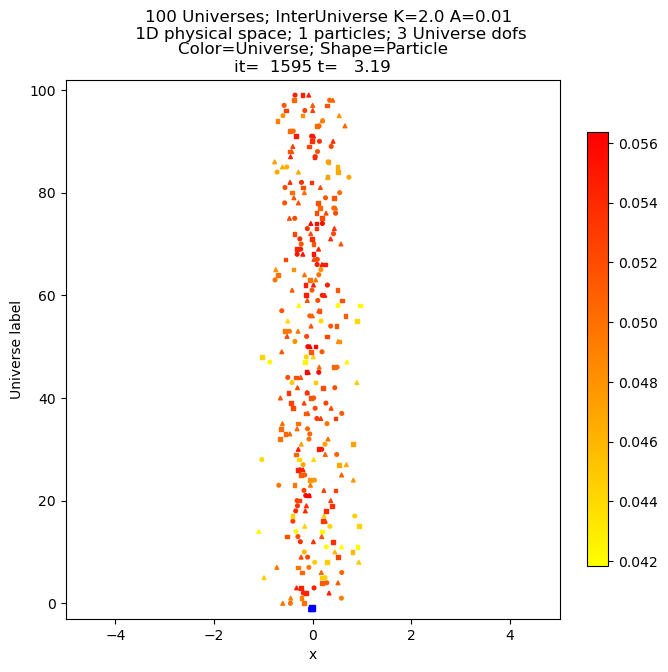

In [16]:
if numDofPartic==1 and numDofUniv>1:
    fig = plt.figure( figsize=(7,7))

    for it, t in enumerate(ts):
        if it%outputEvery==0:
            print(f"\n > It {it}/{numIts}")
            fig.clf()
            trajs = np.load(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")

            # TRAJECTORIES ##############################################
            ax = fig.add_subplot(111)
            #plt.axis(aspect='image');
            ax.set_xlabel("x")
            ax.set_ylabel("Universe label")
            ax.set_title(f"Color=Universe; Shape=Particle\nit={it:6} t={t:7.4}")
            ax.set_xlim((min(xlowers[0]), max(xuppers[0])))
            ax.set_ylim((-3, numTrajs+2))
            # compute the color for each Universe as its pdf
            pdf_Univ = estimate_pdf_over_trajs(trajs[:,:numDofUniv], sigma, real_dtype)
                        
            # Let us compute the baricenter Universe weighted by the estimated pdfs
            baricentrum = np.sum( trajs[:,:numDofUniv]*pdf_Univ[:,np.newaxis]/np.sum(pdf_Univ) , axis=0)
            
            # The color will indicate Universe and marker will indicate particle
            for particle in range(numDofUniv//numDofPartic):
                colormap = ax.scatter(trajs[:,particle*numDofPartic], 
                        np.arange(numTrajs),
                       c=pdf_Univ, cmap='autumn_r', marker=marker_per_particle[particle],
                       s=7, alpha=1)
                ax.plot(baricentrum[particle*numDofPartic], -1,
                       marker=marker_per_particle[particle], markersize=4, color='blue')
                    
            fig.colorbar(colormap, fraction=0.04, location='right')
            fig.suptitle(f"{numTrajs} Universes; InterUniverse K={K:.3} A={A:.3}\n 1D physical space; {numDofUniv//2} particles; {numDofUniv} Universe dofs")
            image=f"./OUTPUTS/MIW/{exp_name}/figs/it_{it}.png"
            plt.savefig(image, dpi=dpi)
            image_paths.append(image)

Generate png

If the physical space within each Universe is 3D and a single particle in each Universe


In [17]:
if numDofPartic==3 and numDofUniv<4:
    every=1 # Only take one data point every this number in each axis to plot
    grid=np.array(np.meshgrid(*nodes_pdf)).swapaxes(1,2)[:,::every, ::every, ::every] #[3,Nx,Ny,Nz]
    print(f"Using a mesh in the plot of {grid.shape}")
    fig = plt.figure( figsize=(14,7))
    #plt.style.use('dark_background')

    for it, t in enumerate(ts):
        if it%outputEvery==0:
            print(f"\n > It {it}/{numIts}")
            fig.clf()
            pdf = np.load(f"./OUTPUTS/MIW/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
            trajs = np.load(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")

            ax = fig.add_subplot(121, projection='3d')
            # PDF TRANSP ############################################################
            maxim = pdf.max()
            minim = pdf.min()
            level_surface = grid[:, pdf>maxim/3]
            colormap = ax.scatter(*level_surface, c=pdf[pdf>maxim/3],
                    cmap='hot_r', s=2, alpha=pdf[pdf>maxim/3]/maxim ) #, antialiased=True)
            ax.set_xlim((xlowers[0,0], xuppers[0,1]))
            ax.set_ylim((xlowers[0,1], xuppers[0,1]))
            ax.set_zlim((xlowers[0,2], xuppers[0,2]))

            fig.colorbar(colormap, fraction=0.04, location='left')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.set_title(f"Probability Density>{maxim/3:.3}\n it={it} t={t:.4}")

            # PDF + TRAJECTORIES ##############################################
            ax = fig.add_subplot(122, projection='3d')
            #colormap = ax.scatter3D(*grid, c=pdf[ ::every, ::every, ::every],
            #               cmap='hot_r', s=0.1, alpha=0.4 ) #, antialiased=True)
            cset = ax.contour(grid[0,:,:,0], grid[1,:,:,0], pdf.sum(axis=2), 7, zdir='z', offset=xlowers[0,2], cmap='hot_r')
            cset = ax.contour(grid[0,:,0,:], pdf.sum(axis=1), grid[2,:,0,:], 7, zdir='y', offset=xuppers[0,1], cmap='hot_r')
            cset = ax.contour(pdf.sum(axis=0), grid[1,0,:,:], grid[2,0,:,:], 7, zdir='x', offset=xlowers[0,0], cmap='hot_r')
            #fig.colorbar(cset, fraction=0.04, location='left')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.set_title(f"Trajectories and Projected Estimated pdf Contours\nColor==Universe; Shape==Particle\nit={it} t={t:.4}")

            # The color will indicate Universe and marker will indicate particle
            for particle in range(numDofUniv//numDofPartic):
                ax.scatter(trajs[:,particle*numDofPartic], 
                        trajs[:,particle*numDofPartic+1],
                        trajs[:,particle*numDofPartic+2], 
                       c='black', marker=marker_per_particle[particle],
                       s=3, alpha=1)
            fig.suptitle(f"InterUniverse K={K:.3} A={A:.3}\nNumber of Universes={numTrajs}")
            image=f"./OUTPUTS/MIW/{exp_name}/figs/it_{it}.png"
            plt.savefig(image, dpi=dpi)
            image_paths.append(image)


Generate png

If the physical space within each Universe is 2D and a single particle per Universe

In [18]:
if numDofPartic==2 and numDofUniv<3:
    every=1 # Only take one data point every this number in each axis to plot
    grid=np.array(np.meshgrid(*nodes_pdf)).swapaxes(-2,-1)[:,::every, ::every] #[2,Nx::ev,Ny]
    print(f"Using a mesh in the plot of {grid.shape}")
    fig = plt.figure( figsize=(14,7))

    for it, t in enumerate(ts):
        if it%outputEvery==0:
            print(f"\n > It {it}/{numIts}")
            fig.clf()          
            pdf = np.load(f"./OUTPUTS/MIW/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
            trajs = np.load(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
            ax = fig.add_subplot(121, projection='3d')
            maxim = pdf.max()
            minim = pdf.min()
            # PDF ############################################################
            colormap = ax.plot_surface(grid[0], grid[1], pdf, rcount=50, ccount=50,
                    cmap='RdYlBu')
            fig.colorbar(colormap, fraction=0.04, location='left')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("Probability Density")
            ax.set_title(f"Probability Density it={it} t={t:.4}")
            cset = ax.contour(grid[0], grid[1], pdf, 7, zdir='x', 
                              offset=xlowers[0,0], cmap='RdYlBu', vmax=maxim, vmin=minim)
            cset = ax.contour(grid[0], grid[1], pdf, 7, zdir='y',
                              offset=xuppers[0,1], cmap='RdYlBu', vmax=maxim, vmin=minim)

            # PDF + TRAJECTORIES ##############################################
            ax = fig.add_subplot(122)
            colormap = ax.imshow(pdf.T, 
                 extent=[xlowers[0,0], xuppers[0,0], xlowers[0,1], xuppers[0,1]]
                                 , origin='lower',cmap='RdYlBu')
            #plt.axis(aspect='image');
            fig.colorbar(colormap, fraction=0.04, location='right')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_title(f"Trajectories and Probability Density\n it={it} t={t:.4}")
            # The color will indicate Universe and marker will indicate particle
            for particle in range(numDofUniv//numDofPartic):
                ax.scatter(trajs[:,particle*numDofPartic], 
                        trajs[:,particle*numDofPartic+1],
                       c='black', marker=marker_per_particle[particle],
                       s=3, alpha=1)
            fig.suptitle(f"InterUniverse K={K:.3} A={A:.3}\nNumber of Universes={numTrajs}")
            image=f"./OUTPUTS/MIW/{exp_name}/figs/it_{it}.png"
            plt.savefig(image, dpi=dpi)
            image_paths.append(image)

If the physical space within each Universe is 1D and a single particle per Universe

In [19]:
if numDofPartic==1 and numDofUniv<3:
    os.makedirs(f"./OUTPUTS/MIW/{exp_name}/figs/", exist_ok=True)
    image_paths = []
    dpi = 100
    fig = plt.figure( figsize=(14,7))

    for it, t in enumerate(ts):
        if it%outputEvery==0:
            print(f"\n > It {it}/{numIts}")

            fig.clf()
            pdf = np.load(f"./OUTPUTS/MIW/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
            trajs = np.load(f"./OUTPUTS/MIW/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")

            # PDF + POTENTIAL + TRAJECTORIES ##############################################
            ax = fig.add_subplot(111)
            ax.plot(grid_pdf[:,0], pdf, label="Probablity Density")
            ax.set_xlabel("x")
            ax.set_ylabel("pdf")
            ax.set_title(f"Trajectories and Probability Density\n it={it} t={t:.4}")
            plt.legend()
            ax2=ax.twinx()
            ax2.plot(grid_potential[:,0], potential_field, label="Potential", color=u'#ff7f0e')        
            ax2.plot(trajs[:,0], [np.mean(potential_field)]*numTrajs, 'o',color='black',
                    markersize=1,label="Bohmian Trajectories")
            ax2.set_ylabel("Potential")
            image=f"./OUTPUTS/MIW/{exp_name}/figs/it_{it}.png"
            plt.legend()
            plt.savefig(image, dpi=dpi)
            image_paths.append(image)      

Generate gif

In [20]:
import imageio
fps=7
images_for_animation = [ imageio.v2.imread(image_path) for image_path in image_paths]
imageio.mimsave(f'./OUTPUTS/MIW/{exp_name}/MIW_Verlet_{exp_name}.gif', images_for_animation, duration=fps**-1*len(images_for_animation))

Erase png

In [21]:
#for image_path in image_paths:
#    os.remove(image_path)

In [22]:
trajs = np.arange(30).reshape(5,6)
numDofPartic = 3
trajsPerParticl = trajs.reshape(trajs.shape[0],
                  trajs.shape[1]//numDofPartic,
                  numDofPartic) #[numTrajs, numPartcls, dimPerParticl]
relativeVecsPerParticle=(trajsPerParticl[:,:,:,np.newaxis]-trajsPerParticl[:,np.newaxis,:,:].swapaxes(-2,-1)).swapaxes(-2,-1)
# [numTrajs, numPartcls, numParticls, dimPerParticl] 
# (k,i,j) is x^part_i_xik-x^part_j_xik vector [dimPerPartcl]

In [23]:
print(trajs)
relative_vecs = (trajs[:,:,None]-trajs[:,:,None].T).swapaxes(1,2)
# (i,j) is the x_xi1-x_xi2 [dofUniv] vec
relative_distances = np.linalg.norm(relative_vecs, axis=-1)

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]]


In [24]:
relative_distances[np.arange(len(trajs)), np.arange(len(trajs))]=np.inf
relative_distances

array([[        inf, 14.69693846, 29.39387691, 44.09081537, 58.78775383],
       [14.69693846,         inf, 14.69693846, 29.39387691, 44.09081537],
       [29.39387691, 14.69693846,         inf, 14.69693846, 29.39387691],
       [44.09081537, 29.39387691, 14.69693846,         inf, 14.69693846],
       [58.78775383, 44.09081537, 29.39387691, 14.69693846,         inf]])

In [25]:
relative_distances = np.linalg.norm(relativeVecsPerParticle, axis=-1, keepdims=True) 
relative_distances[:,np.arange(3), np.arange(3)]=np.inf
relative_distances

IndexError: index 2 is out of bounds for axis 1 with size 2